<a href="https://colab.research.google.com/github/Yasminebenhamadi/NMA/blob/main/DL/W2D3_Tutorial2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Bonus Tutorial: Facial recognition using modern convnets

**Week 2, Day 3: Modern Convnets**

**By Neuromatch Academy**

__Content creators:__ Laura Pede, Richard Vogg, Marissa Weis, Timo Lüddecke, Alexander Ecker

__Content reviewers:__ Arush Tagade, Polina Turishcheva, Yu-Fang Yang, Bettina Hein, Melvin Selim Atay, Kelson Shilling-Scrivo

__Content editors:__ Roberto Guidotti, Spiros Chavlis

__Production editors:__ Anoop Kulkarni, Roberto Guidotti, Cary Murray, Gagana B, Spiros Chavlis

<br>

*Notebook is based on an initial version by Ben Heil*

---
# Setup

In [ ]:
# @title Install dependencies
# @markdown Install `facenet` - A model used to do facial recognition
!pip install facenet-pytorch --quiet
!pip install Pillow --quiet

Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/pip/_vendor/pkg_resources/__init__.py", line 3021, in _dep_map
    return self.__dep_map
  File "/usr/local/lib/python3.7/dist-packages/pip/_vendor/pkg_resources/__init__.py", line 2815, in __getattr__
    raise AttributeError(attr)
AttributeError: _DistInfoDistribution__dep_map

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/pip/_internal/cli/base_command.py", line 180, in _main
    status = self.run(options, args)
  File "/usr/local/lib/python3.7/dist-packages/pip/_internal/cli/req_command.py", line 199, in wrapper
    return func(self, options, args)
  File "/usr/local/lib/python3.7/dist-packages/pip/_internal/commands/install.py", line 385, in run
    conflicts = self._determine_conflicts(to_install)
  File "/usr/local/lib/python3.7/dist-packages/pip/_internal/commands/install.py", line 515, in _det

In [ ]:
# Imports
import glob
import torch

import numpy as np
import sklearn.decomposition
import matplotlib.pyplot as plt

from PIL import Image

from torchvision import transforms
from torchvision.utils import make_grid
from torchvision.datasets import ImageFolder

from facenet_pytorch import MTCNN, InceptionResnetV1

In [ ]:
# @title Set random seed

# @markdown Executing `set_seed(seed=seed)` you are setting the seed

# For DL its critical to set the random seed so that students can have a
# baseline to compare their results to expected results.
# Read more here: https://pytorch.org/docs/stable/notes/randomness.html

# Call `set_seed` function in the exercises to ensure reproducibility.
import random
import torch

def set_seed(seed=None, seed_torch=True):
  """
  Function that controls randomness. NumPy and random modules must be imported.

  Args:
    seed : Integer
      A non-negative integer that defines the random state. Default is `None`.
    seed_torch : Boolean
      If `True` sets the random seed for pytorch tensors, so pytorch module
      must be imported. Default is `True`.

  Returns:
    Nothing.
  """
  if seed is None:
    seed = np.random.choice(2 ** 32)
  random.seed(seed)
  np.random.seed(seed)
  if seed_torch:
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

  print(f'Random seed {seed} has been set.')


# In case that `DataLoader` is used
def seed_worker(worker_id):
  """
  DataLoader will reseed workers following randomness in
  multi-process data loading algorithm.

  Args:
    worker_id: integer
      ID of subprocess to seed. 0 means that
      the data will be loaded in the main process
      Refer: https://pytorch.org/docs/stable/data.html#data-loading-randomness for more details

  Returns:
    Nothing
  """
  worker_seed = torch.initial_seed() % 2**32
  np.random.seed(worker_seed)
  random.seed(worker_seed)

In [ ]:
# @title Set device (GPU or CPU). Execute `set_device()`
# especially if torch modules used.

# Inform the user if the notebook uses GPU or CPU.

def set_device():
  """
  Set the device. CUDA if available, CPU otherwise

  Args:
    None

  Returns:
    Nothing
  """
  device = "cuda" if torch.cuda.is_available() else "cpu"
  if device != "cuda":
    print("WARNING: For this notebook to perform best, "
        "if possible, in the menu under `Runtime` -> "
        "`Change runtime type.`  select `GPU` ")
  else:
    print("GPU is enabled in this notebook.")

  return device

In [ ]:
SEED = 2021
set_seed(seed=SEED)
DEVICE = set_device()

Random seed 2021 has been set.
GPU is enabled in this notebook.


---
# Section 1: Face Recognition

*Time estimate: ~12mins*

## Section 1.1: Download and prepare the data

In [ ]:
# @title Download Faces Data
import requests, zipfile, io, os

# Original link: https://github.com/ben-heil/cis_522_data.git
url = 'https://osf.io/2kyfb/download'

fname = 'faces'

if not os.path.exists(fname+'zip'):
  print("Data is being downloaded...")
  r = requests.get(url, stream=True)
  z = zipfile.ZipFile(io.BytesIO(r.content))
  z.extractall()
  print("The download has been completed.")
else:
  print("Data has already been downloaded.")

Data is being downloaded...
The download has been completed.


## Section 1.2: View and transform the data

A well-trained facial recognition system should be able to map different images of the same individual relatively close together. We will load 15 images of three individuals (maybe you know them - then you can see that your brain is quite well in facial recognition).

After viewing the images, we will transform them: MTCNN ([github repo](https://github.com/ipazc/mtcnn)) detects the face and crops the image around the face. Then we stack all the images together in a tensor.

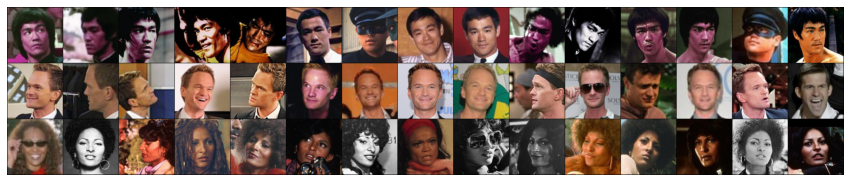

In [ ]:
# @title Display Images
# @markdown Here are the source images of Bruce Lee, Neil Patrick Harris, and Pam Grier
train_transform = transforms.Compose((transforms.Resize((256, 256)),
                                      transforms.ToTensor()))

face_dataset = ImageFolder('faces', transform=train_transform)

image_count = len(face_dataset)

face_loader = torch.utils.data.DataLoader(face_dataset,
                                          batch_size=45,
                                          shuffle=False)

dataiter = iter(face_loader)
images, labels = dataiter.next()

# Show images
plt.figure(figsize=(15, 15))
plt.imshow(make_grid(images, nrow=15).permute(1, 2, 0))
plt.axis('off')
plt.show()

In [ ]:
# @title Image Preprocessing Function
def process_images(image_dir: str, size=256):
  """
  This function returns two tensors for the
  given image dir: one usable for inputting into the
  facenet model, and one that is [0,1] scaled for
  visualizing

  Parameters:
    image_dir: string
      The glob corresponding to images in a directory
    size: int
      Size [default: 256]

  Returns:
    model_tensor: torch.tensor
      A image_count x channels x height x width
      tensor scaled to between -1 and 1,
      with the faces detected and cropped to the center
      using mtcnn
    display_tensor: torch.tensor
      A transformed version of the model
      tensor scaled to between 0 and 1
  """
  mtcnn = MTCNN(image_size=size, margin=32)
  images = []
  for img_path in glob.glob(image_dir):
    img = Image.open(img_path)
    # Normalize and crop image
    img_cropped = mtcnn(img)
    images.append(img_cropped)

  model_tensor = torch.stack(images)
  display_tensor = model_tensor / (model_tensor.max() * 2)
  display_tensor += .5

  return model_tensor, display_tensor

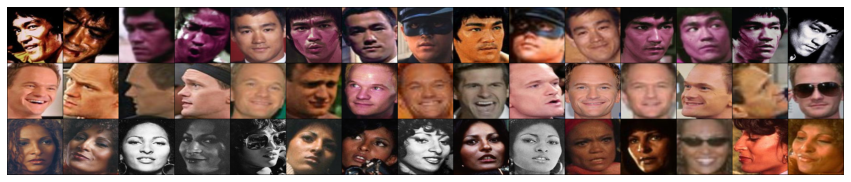

In [ ]:
bruce_tensor, bruce_display = process_images('faces/bruce/*.jpg')
neil_tensor, neil_display = process_images('faces/neil/*.jpg')
pam_tensor, pam_display = process_images('faces/pam/*.jpg')

tensor_to_display = torch.cat((bruce_display, neil_display, pam_display))

plt.figure(figsize=(15, 15))
plt.imshow(make_grid(tensor_to_display, nrow=15).permute(1, 2, 0))
plt.axis('off')
plt.show()

## Section 1.3: Embedding with a pretrained network 

We load a pretrained facial recognition model called [FaceNet](https://github.com/timesler/facenet-pytorch). It was trained on the [VGGFace2](https://github.com/ox-vgg/vgg_face2) dataset which contains 3.31 million images of 9131 individuals.

We use the pretrained model to calculate embeddings for all of our input images.

In [ ]:
resnet = InceptionResnetV1(pretrained='vggface2').eval().to(DEVICE)

In [ ]:
# Calculate embedding
resnet.classify = False
bruce_embeddings = resnet(bruce_tensor.to(DEVICE))
neil_embeddings = resnet(neil_tensor.to(DEVICE))
pam_embeddings = resnet(pam_tensor.to(DEVICE))

In [ ]:
embedding_tensor = torch.cat((bruce_embeddings,
                              neil_embeddings,
                              pam_embeddings)).to(device='cpu')

pca = sklearn.decomposition.PCA(n_components=2)
pca_tensor = pca.fit_transform(embedding_tensor.detach().cpu().numpy())

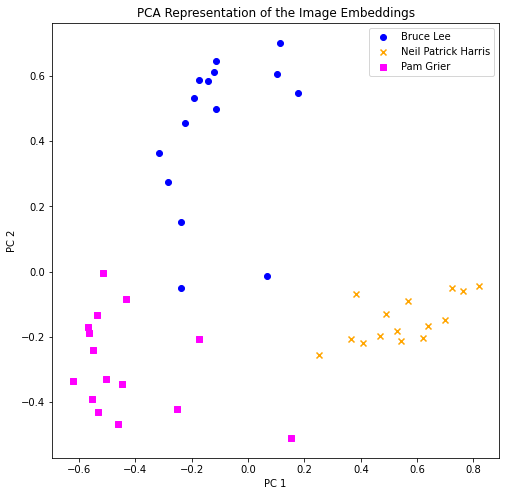

In [ ]:
num = 15
categs = 3
colors = ['blue', 'orange', 'magenta']
labels = ['Bruce Lee', 'Neil Patrick Harris', 'Pam Grier']
markers = ['o', 'x', 's']
plt.figure(figsize=(8, 8))
for i in range(categs):
   plt.scatter(pca_tensor[i*num:(i+1)*num, 0],
               pca_tensor[i*num:(i+1)*num, 1],
               c=colors[i],
               marker=markers[i], label=labels[i])
plt.legend()
plt.title('PCA Representation of the Image Embeddings')
plt.xlabel('PC 1')
plt.ylabel('PC 2')
plt.show()

---
# Section 2: Ethics – bias/discrimination due to pre-training datasets

*Time estimate: ~19mins*

## Section 2.1: Download the Data

In [ ]:
# @title Run this cell to get the data

# Original link: https://github.com/richardvogg/face_sample.git
url = 'https://osf.io/36wyh/download'
fname = 'face_sample2'

if not os.path.exists(fname+'zip'):
  print("Data is being downloaded...")
  r = requests.get(url, stream=True)
  z = zipfile.ZipFile(io.BytesIO(r.content))
  z.extractall()
  print("The download has been completed.")
else:
  print("Data has already been downloaded.")

Data is being downloaded...
The download has been completed.


## Section 2.2: Load, view and transform the data

In [ ]:
black_female_tensor, black_female_display = process_images('face_sample2/??_1_1_*.jpg', size=150)
white_female_tensor, white_female_display = process_images('face_sample2/??_1_0_*.jpg', size=150)

In [ ]:
print(white_female_tensor.shape)
print(black_female_tensor.shape)

torch.Size([49, 3, 150, 150])
torch.Size([49, 3, 150, 150])


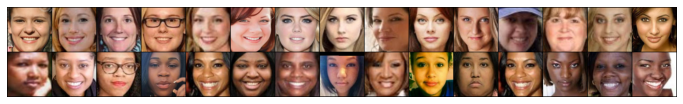

In [ ]:
# @title Visualize some example faces
tensor_to_display = torch.cat((white_female_display[:15],
                               black_female_display[:15]))

plt.figure(figsize=(12, 12))
plt.imshow(make_grid(tensor_to_display, nrow = 15).permute(1, 2, 0))
plt.axis('off')
plt.show()

## Section 2.3: Calculate embeddings

In [ ]:
resnet.classify = False
black_female_embeddings = resnet(black_female_tensor.to(DEVICE))
white_female_embeddings = resnet(white_female_tensor.to(DEVICE))

In [ ]:
# @title Function to calculate pairwise distances

# @markdown [`torch.cdist`](https://pytorch.org/docs/stable/generated/torch.cdist.html) is used

def calculate_pairwise_distances(embedding_tensor):
  """
  This function calculates the distance
  between each pair of image embeddings
  in a tensor using the `torch.cdist`.

  Parameters:
    embedding_tensor : torch.Tensor
      A num_images x embedding_dimension tensor

  Returns:
    distances : torch.Tensor
      A num_images x num_images tensor
      containing the pairwise distances between
      each to image embedding
  """

  distances = torch.cdist(embedding_tensor, embedding_tensor)

  return distances

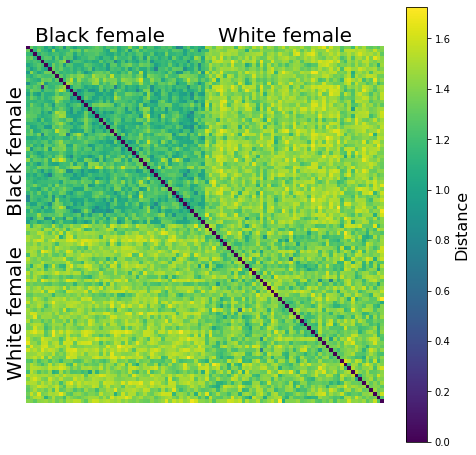

In [ ]:
# @title Visualize the distances

embedding_tensor = torch.cat((black_female_embeddings,
                              white_female_embeddings)).to(device='cpu')

distances = calculate_pairwise_distances(embedding_tensor)

plt.figure(figsize=(8, 8))
plt.imshow(distances.detach().cpu().numpy())
plt.annotate('Black female', (2, -0.5), fontsize=20, va='bottom')
plt.annotate('White female', (52, -0.5), fontsize=20, va='bottom')
plt.annotate('Black female', (-0.5, 45), fontsize=20, rotation=90, ha='right')
plt.annotate('White female', (-0.5, 90), fontsize=20, rotation=90, ha='right')
cbar = plt.colorbar()
cbar.set_label('Distance', fontsize=16)
plt.axis('off')
plt.show()

---
# Section 3: Within Sum of Squares

*Time estimate: ~10mins*


In [ ]:
# @title Function to calculate WSS

def wss(group):
  """
  This function returns the sum of squared distances
  of the N vectors of a
  group tensor (N x K) to its centroid (1 x K).
   Hints:
    - to calculate the centroid, torch.mean()
      will be of use.
    - We need the mean of the N=49 observations.
      If our input tensor is of size
      N x K, we expect the centroid to be of
      dimensions 1 x K.
      Use the axis argument within torch.mean

  Args:
    group: torch.tensor
      A image_count x embedding_size tensor

  Returns:
    sum_sq: torch.tensor
      A 1x1 tensor with the sum of squared distances.
    """

  centroid = torch.mean(group, axis=0)
  distance = torch.linalg.norm(group - centroid.view(1, -1), axis=1)
  sum_sq = torch.sum(distance**2)
  return sum_sq

In [ ]:
# @markdown Let's calculate the WSS for the two groups of our example.

print(f"Black female embedding WSS: {np.round(wss(black_female_embeddings).item(), 2)}")
print(f"White female embedding WSS: {np.round(wss(white_female_embeddings).item(), 2)}")

Black female embedding WSS: 34.2
White female embedding WSS: 44.6
